In [1]:
from __future__ import division, print_function
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
import tensorflow as tf
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)

In [2]:
from tf_unet import image_util
from tf_unet import unet
from tf_unet import util

### Train and save model

In [3]:
prediction_path = "./prediction_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset"
output_path = "./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset"
training_data = image_util.ImageDataProvider("./data_trainset/*.tif")

Number of files used: 26
Number of channels: 1
Number of classes: 2


In [4]:
i=26 #number of images
x_train, y_train = training_data(i)
print(x_train.shape)

(26, 1000, 1000, 1)


In [ ]:
epochs = 50
training_iters=32

net = unet.Unet(layers=3, features_root=32, channels=1, n_class=2)
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2,learning_rate=1.4,decay_rate=0.95))

path = trainer.train(training_data, output_path, training_iters=training_iters, epochs=epochs, 
                     display_step=1, prediction_path=prediction_path)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


2020-07-05 18:38:50,755 From /home/yao/anaconda3/lib/python3.7/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


loss in the final epoch is 0.016107001036857582


(0.0, 1.0)

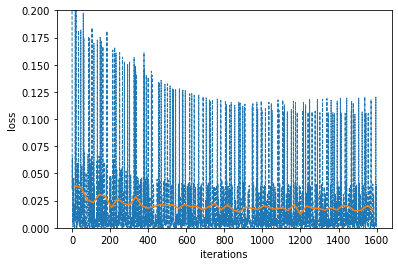

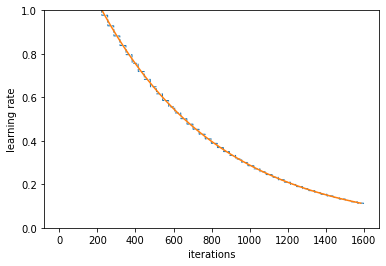

In [6]:
loss,loss_,lr,lr_=[],[],[],[]

eventfile = glob.glob(output_path+'/*events*')[0]

for event in tf.train.summary_iterator(eventfile):
    for v in event.summary.value:
        if v.tag == 'loss':
            loss.append(v.simple_value)
        if v.tag == 'learning_rate':
            lr.append(v.simple_value)

iter = np.arange(0, len(loss))
iter_=[]
epoch = np.arange(0, epochs)

for i in np.arange(0,len(loss),int(len(loss)/epochs)):
    loss_.append(np.mean(loss[i:i+int(len(loss)/epochs)]))
    lr_.append(np.mean(lr[i:i+int(len(lr)/epochs)]))
    iter_.append(np.mean(iter[i:i+int(len(iter)/epochs)]))

plt.figure()
plt.plot(iter, loss, lw=1, linestyle = '--')
plt.plot(iter_, loss_)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim([0,0.2])
print('loss in the final epoch is '+ str(loss_[len(epoch)-1]))
plt.figure()
plt.plot(iter, lr, lw=1, linestyle = '--')
plt.plot(iter_, lr_)
plt.xlabel('iterations')
plt.ylabel('learning rate')
plt.ylim([0,1])

### Validation set performance

In [7]:
#prepare validation data
valid_data = image_util.ImageDataProvider("./data_validset/*.tif")
i=6 #number of images
x_valid, y_valid = valid_data(i)

net = unet.Unet(layers=3, features_root=32, channels=1, n_class=2)
prediction = net.predict(output_path+"/model.ckpt", x_valid)

print('input shape:',x_valid.shape)
print('label shape:',y_valid.shape)
print('prediction shape:',prediction.shape)

2020-05-18 01:15:51,313 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 6
Number of channels: 1
Number of classes: 2
Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-05-18 01:15:52,049 From /home/yao/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


2020-05-18 01:15:52,050 Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt
2020-05-18 01:15:52,123 Model restored from file: ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


input shape: (6, 1000, 1000, 1)
label shape: (6, 1000, 1000, 2)
prediction shape: (6, 960, 960, 2)


prediction maximum value: 0.49733377
prediction minimum value: 8.978701e-06
label maximum value: 1.0
label minimum value: 0.0
label shape: (5529600,)
prediction shape: (5529600,)


/home/yao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'f1-score')

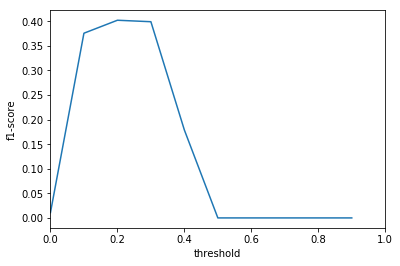

In [8]:
valid_y = y_valid[...,20:980,20:980,1].flatten()
valid_y_predict = prediction[...,1].flatten()

print('prediction maximum value:',max(valid_y_predict))
print('prediction minimum value:',min(valid_y_predict))
print('label maximum value:',max(valid_y))
print('label minimum value:',min(valid_y))
print('label shape:', valid_y.shape)
print('prediction shape:',valid_y_predict.shape)

f1 = []
thr = np.arange(0,1,0.1)
for i in thr:
    f1.append(f1_score(valid_y, (valid_y_predict > i)))
    
plt.figure()
plt.plot(thr, f1)
plt.xlim([0,1])
plt.xlabel('threshold')
plt.ylabel('f1-score')

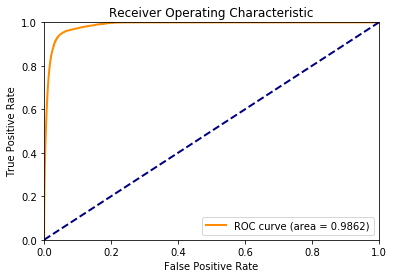

AUC =  0.9862497231179126


In [9]:
fpr, tpr, thresholds = roc_curve(valid_y, valid_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)

### Testing set performance

In [10]:
#prepare test data
test_data = image_util.ImageDataProvider("./data_testset/*.tif")
i=6 #number of images
x_test, y_test = test_data(i)

prediction = net.predict(output_path+"/model.ckpt", x_test)

print('input shape:',x_test.shape)
print('label shape:',y_test.shape)
print('prediction shape:',prediction.shape)

Number of files used: 6
Number of channels: 1
Number of classes: 2
INFO:tensorflow:Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


2020-05-18 01:16:35,114 Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt
2020-05-18 01:16:35,176 Model restored from file: ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


input shape: (6, 1000, 1000, 1)
label shape: (6, 1000, 1000, 2)
prediction shape: (6, 960, 960, 2)


In [11]:
test_y = y_test[...,20:980,20:980,1].flatten()
test_y_predict = prediction[...,1].flatten()

print('prediction maximum value:',max(test_y_predict))
print('prediction minimum value:',min(test_y_predict))
print('label maximum value:',max(test_y))
print('label minimum value:',min(test_y))
print('label shape:', test_y.shape)
print('prediction shape:',test_y_predict.shape)

thr = 0.2
print('confusion matrix for threshold=', thr,':')
print(classification_report(test_y, (test_y_predict > thr)))

prediction maximum value: 0.4920407
prediction minimum value: 8.606922e-06
label maximum value: 1.0
label minimum value: 0.0
label shape: (5529600,)
prediction shape: (5529600,)
confusion matrix for threshold= 0.2 :
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   5454915
         1.0       0.49      0.64      0.56     74685

   micro avg       0.99      0.99      0.99   5529600
   macro avg       0.74      0.81      0.77   5529600
weighted avg       0.99      0.99      0.99   5529600



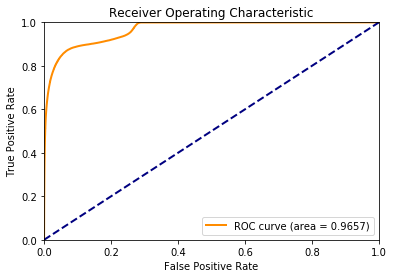

AUC =  0.965675855986186


In [12]:
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)

### Visualize prediction

In [13]:
test_data = image_util.ImageDataProvider("./data_ross/*.tif")
i=2 #number of images
x_test, y_test = test_data(i)
print(x_test.shape)
print(y_test.shape)
prediction = net.predict(output_path+"/model.ckpt", x_test)

Number of files used: 2
Number of channels: 1
Number of classes: 2
(2, 1000, 1000, 1)
(2, 1000, 1000, 2)
Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-07-05 18:39:15,493 From /home/yao/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


2020-07-05 18:39:15,494 Restoring parameters from ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt
2020-07-05 18:39:15,553 Model restored from file: ./trained_3layers_feature32_epoch50_LR1.4_D0.95_M0.2_data_trainset_20190717/model.ckpt


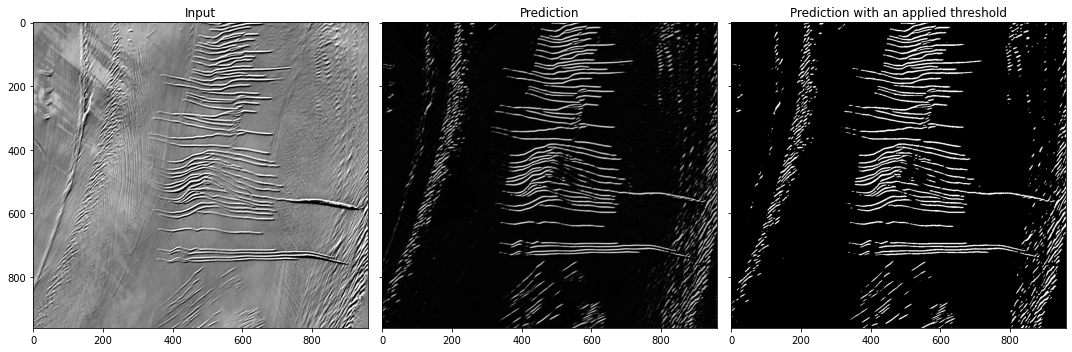

In [14]:
# display
i=1#sample index
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
ax[0].imshow(x_test[i,...,0], aspect="auto")
ax[1].imshow(prediction[i,...,1], aspect="auto")
mask = prediction[i,...,1] > thr
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Prediction")
ax[2].set_title("Prediction with an applied threshold")
fig.tight_layout()